In [67]:
import torch
import torchvision.transforms as trans
import numpy as np
import matplotlib.pyplot as plt

import train
import vmdata
import more_trans
import salicae

%matplotlib inline

In [68]:
root = vmdata.prepare_dataset_root(9, (8, 0, 0))
dset = vmdata.VideoDataset(root, transform=trans.Compose([
        more_trans.GaussianBlur(), trans.ToTensor(),
        trans.Normalize(*vmdata.get_normalization_stats(root))]))

In [69]:
def tn(tensor):
    return tensor[0].numpy().transpose((1,2,0))
denml = more_trans.DeNormalize(*vmdata.get_normalization_stats(root))

In [70]:
ls -rt save

checkpoint_520.pth  checkpoint_600.pth  checkpoint_170.pth  checkpoint_250.pth
checkpoint_0.pth    checkpoint_90.pth   checkpoint_690.pth  checkpoint_780.pth
checkpoint_10.pth   checkpoint_610.pth  checkpoint_180.pth  checkpoint_260.pth
checkpoint_530.pth  checkpoint_100.pth  checkpoint_700.pth  checkpoint_790.pth
checkpoint_20.pth   checkpoint_620.pth  checkpoint_710.pth  checkpoint_270.pth
checkpoint_540.pth  checkpoint_110.pth  checkpoint_190.pth  checkpoint_800.pth
checkpoint_30.pth   checkpoint_630.pth  checkpoint_720.pth  checkpoint_280.pth
checkpoint_550.pth  checkpoint_120.pth  checkpoint_200.pth  checkpoint_810.pth
checkpoint_40.pth   checkpoint_640.pth  checkpoint_730.pth  checkpoint_290.pth
checkpoint_560.pth  checkpoint_130.pth  checkpoint_210.pth  checkpoint_820.pth
checkpoint_50.pth   checkpoint_650.pth  checkpoint_740.pth  checkpoint_300.pth
checkpoint_570.pth  checkpoint_140.pth  checkpoint_220.pth  checkpoint_830.pth
checkpoint_60.pth   checkpoint_660.pth  checkpoint_7

In [71]:
net = salicae.SaliencyCAE(vgg_arch='Ashallow', batch_norm=False)
state_dict = torch.load('save/checkpoint_100.pth', map_location='cpu')
net.load_state_dict(state_dict)

In [65]:
orig = dset[177]  # 177
with torch.no_grad():
    sali = net(orig[None,:]).detach()
mask = tn(denml(orig.clone()[None,:]) * sali)
orig = tn(denml(orig.clone()[None,:]))
sali = tn(sali)

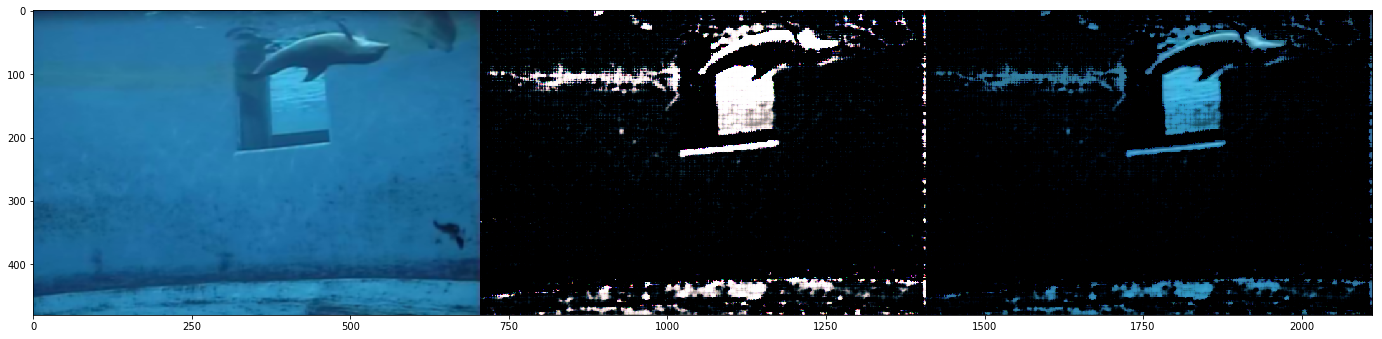

In [66]:
plt.figure(figsize=(24,8))
plt.imshow(np.concatenate((orig, sali, mask), axis=1));

In [31]:
mw = train.MovingWindowBatchSampler(dset, width=30, drop_margin=True)
sam = train.BatchMovingWindowBatchSampler(mw, batch_size=1, drop_last=True)
dl = torch.utils.data.DataLoader(dset, batch_sampler=sam)

In [ ]:
for bid, frames in enumerate(dl):
    if bid == 256-30:
        break

In [84]:
inputs, bgs = train.reduce_moving_window(mw, frames, train.mw_median)
salis = net(inputs).detach()

In [90]:
def recover_from_window(w):
    return tn(denml(w[-1][None,:].clone()))

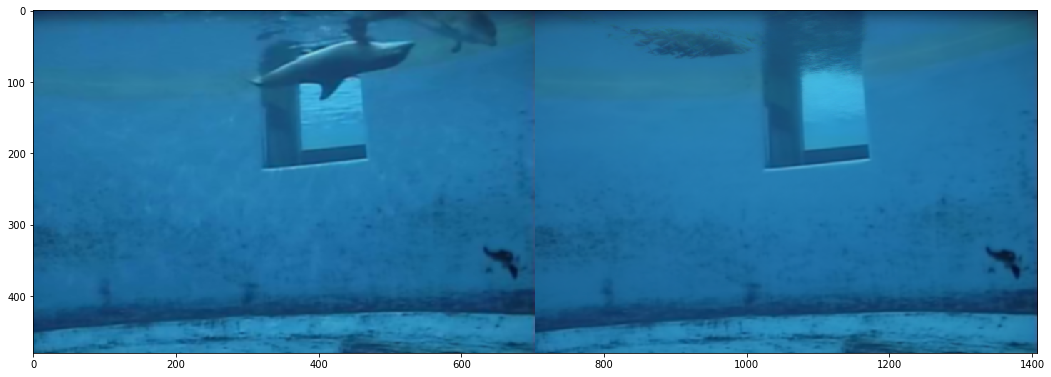

In [92]:
plt.figure(figsize=(18,8))
plt.imshow(np.concatenate(map(recover_from_window, [inputs, bgs]), axis=1));

In [93]:
mse = torch.nn.MSELoss()

In [94]:
mse(bgs[-1][None,:], inputs[-1][None,:])

tensor(0.1184)

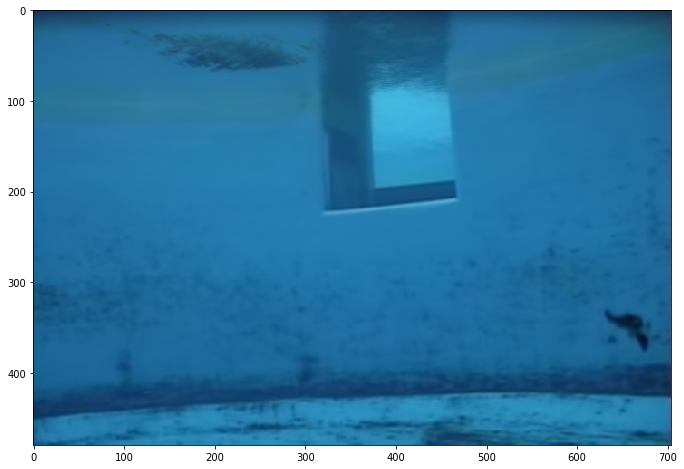

In [99]:
plt.figure(figsize=(18,8))
plt.imshow(recover_from_window(salis*inputs+(1-salis)*bgs));

In [33]:
dset.release_mmap()